In [1]:
import jax
jax.config.update("jax_enable_x64", True)

In [2]:
import scvi
import scanpy as sc
import os
import juniper

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
split = 5
output_dir = "/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex"
adata_train = sc.read(os.path.join(output_dir, f"adata_train_{split}.h5ad"))
adata_test = sc.read(os.path.join(output_dir, f"adata_test_{split}.h5ad"))
adata_ood = sc.read(os.path.join(output_dir, f"adata_ood_{split}.h5ad")) 




/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [4]:
juniper.latent.model.FactorVI.setup_anndata(adata_train)
vae = juniper.latent.model.FactorVI(adata_train, count_input=False, n_latent = 16, encoder_layers= (1024, 1024, 1024), decoder_layers = (1024, 1024, 1024), disentangling_weight=0.1, kld_weight=0.5)


/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [5]:
vae.train(
    max_epochs=2000,
    batch_size=1024,
    plan_kwargs=dict(
        lr=1e-4,
    ),
    early_stopping=True,
    early_stopping_patience=20,
)

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/dominik.klein/mambaforge/envs/ot_pert_geno ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/dominik.klein/mambaforge/envs/ot_pert_geno ...
You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 3g.20gb') that has Tensor Cores. To prop

Epoch 1/2000:   0%|          | 0/2000 [00:00<?, ?it/s]

/ictstr01/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:385: You have overridden `transfer_batch_to_device` in `LightningModule` but have passed in a `LightningDataModule`. It will use the implementation from `LightningModule` instance.


Epoch 98/2000:   5%|▍         | 98/2000 [09:25<3:03:00,  5.77s/it, v_num=1, train_loss=31.5, rec_loss=29, kld_loss=20.6]   
Monitored metric reconstruction_loss_validation did not improve in the last 20 records. Best score: 28.416. Signaling Trainer to stop.


In [6]:
adata_train.obsm["X_scVI"] = vae.get_latent_representation(adata_train, give_mean=True)

In [10]:
adata_ood.obsm["X_scVI"] = vae.get_latent_representation(adata_ood, give_mean=True)

In [18]:
adata_ood.obsm["reconstruction"] = vae.get_reconstructed_expression(adata_ood)

In [11]:
sc.pp.neighbors(adata_ood, use_rep="X_scVI")
sc.tl.umap(adata_ood)

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


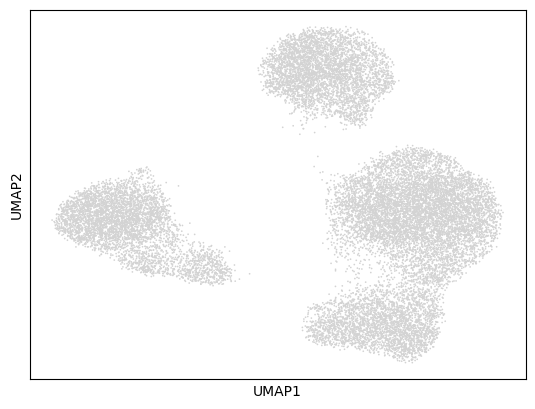

In [12]:
sc.pl.umap(adata_ood)

In [13]:
adata_ood.obsm["X_scVI"].var(axis=0)

array([1.1700907 , 0.22036327, 1.0669466 , 0.83721423, 1.1691234 ,
       0.8606094 , 0.7694293 , 1.2075415 , 0.8025904 , 0.85744727,
       0.85671055, 0.7769129 , 0.948903  , 0.892471  , 1.0498558 ,
       1.076141  ], dtype=float32)

In [19]:
from sklearn.metrics import r2_score
import numpy as np

r2_score(np.array(np.mean(adata_ood.X, axis=0))[0,:], np.mean(adata_ood.obsm["reconstruction"], axis=0))

0.980737930820257

In [9]:
adata_train.obsm["reconstruction"] = vae.get_reconstructed_expression(adata_ood, give_mean=True)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


KeyError: 'X_scVI'

In [ ]:
from sklearn.metrics import pairwise_distances, r2_score
import numpy as np

In [ ]:
r2_score(np.array(np.mean(adata_train.X, axis=0))[0,:], np.mean(adata_train.obsm["reconstruction"], axis=0))

In [8]:
vae

Training status: Trained

In [9]:
r2_score(np.array(np.mean(adata_train.X, axis=0))[0,:], np.mean(adata_train.obsm["reconstruction"], axis=0))

0.9871165328301995

In [10]:
adata_ood.obsm["X_scVI"] = vae.get_latent_representation(adata_ood, give_mean=True)
adata_ood.obsm["reconstruction"] = vae.get_reconstructed_expression(adata_ood, give_mean=True)
r2_score(np.mean(adata_ood.obsm["reconstruction"], axis=0), np.array(np.mean(adata_ood.X, axis=0))[0,:])

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


0.963582553844818

In [11]:
adata_test.obsm["X_scVI"] = vae.get_latent_representation(adata_test, give_mean=True)
adata_test.obsm["reconstruction"] = vae.get_reconstructed_expression(adata_test, give_mean=True)
r2_score(np.mean(adata_test.obsm["reconstruction"], axis=0), np.array(np.mean(adata_test.X, axis=0))[0,:])

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot_scvi/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


0.9871515641131152

In [12]:
save_path = "/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/sciplex_factorvi_test"
vae.save(save_path, overwrite=True)

In [13]:
adata_ood.uns['rank_genes_groups_cov_all'] = adata_train.uns['rank_genes_groups_cov_all']

In [14]:
adata_train.write(os.path.join(output_dir, "adata_train_biolord_split_30_with_scvi_16.h5ad"))
adata_test.write(os.path.join(output_dir, "adata_test_biolord_split_30_with_scvi_16.h5ad"))
adata_ood.write(os.path.join(output_dir, "adata_ood_biolord_split_30_with_scvi_16.h5ad")) 
